### 필요한 라이브러리 설치

In [ ]:
!pip install pefile
!pip install numpy
!pip install sklearn
!pip install lightgbm
!pip install tqdm
!pip install pandas
!pip install graphviz

     |████████████████████████████████| 71kB 3.8MB/s 
  Created wheel for pefile: filename=pefile-2019.4.18-cp36-none-any.whl size=60823 sha256=b0083b1d4fd784aee82e0aa66e7e30733fc062d7461b8476de6a7c511930987b
  Stored in directory: /root/.cache/pip/wheels/1c/a1/95/4f33011a0c013c872fe6f0f364dc463a2588120820e40a30d8
Successfully built pefile


### 구글 드라이브 연동

In [ ]:
from google.colab import drive 
drive_path = '/content/gdrive/'
drive.mount(drive_path)

import sys
sys.path.append(drive_path + "My Drive")

Mounted at /content/gdrive/


## 피처 추출 코드
- https://bit.ly/3amOhp2

## 샘플
- https://bit.ly/31P7Z98

## 학습 데이터 이름
http://tiny.cc/9cdzsz

## 학습 데이터
http://tiny.cc/1cdzsz

## 학습 라벨
http://tiny.cc/gcdzsz

## 검증 데이터 이름
http://tiny.cc/2edzsz

## 검증 데이터
http://tiny.cc/zddzsz

## 검증 라벨
http://tiny.cc/4edzsz


In [ ]:
import glob
import os
import pickle
# import peminer

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


%matplotlib inline

### PE-Miner 코드로 피처 추출

In [ ]:
# PEMINER 에서 사용한 특징의 이름
peminer_header = ['ADVAP132.DLL', 'AWFAXP32.DLL', 'AWFXAB32.DLL', 'AWPWD32.DLL', 'AWRESX32.DLL', 'AWUTIL32.DLL', 'BHNETB.DLL', 'BHSUPP.DLL', 'CCAPI.DLL', 'CCEI.DLL', 'CCPSH.DLL', 'CCTN20.DLL', 'CMC.DLL', 'COMCTL32.DLL', 'COMDLG32.DLL', 'CRTDLL.DLL', 'DCIMAN.DLL', 'DCIMAN32.DLL', 'DSKMAINT.DLL', 'FileHeader.Characteristics', 'FileHeader.Machine', 'FileHeader.NumberOfSections', 'FileHeader.NumberOfSymbols', 'FileHeader.PointerToSymbolTable', 'FileHeader.SizeOfOptionalHeader', 'FileHeader.TimeDateStamp', 'GDI32.DLL', 'GROUP.DLL', 'HYPERTERM.DLL', 'KERNL32.DLL', 'LZ32.DLL', 'MAPI.DLL', 'MAPI32.DLL', 'MFC30.DLL', 'MPR.DLL', 'MSFS32.DLL', 'MSNDUI.DLL', 'MSNET32.DLL', 'MSPST32.DLL', 'MSSHRUI.DLL', 'MSVIEWUT.DLL', 'NAL.DLL', 'NDIS30.DLL', 'NETAPI.DLL', 'NETAPI32.DLL', 'NETBIOS.DLL', 'NETDI.DLL', 'NETSETUP.DLL', 'NWAB32.DLL', 'NWNET32.DLL', 'NWNP32.DLL', 'OLEDLG.DLL', 'OptionalHeader.AddressOfEntryPoint', 'OptionalHeader.BaseOfCode', 'OptionalHeader.BaseOfData', 'OptionalHeader.CheckSum', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BASERELOC.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BASERELOC.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BOUND_IMPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BOUND_IMPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_COM_DESCRIPTOR.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_COM_DESCRIPTOR.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DEBUG.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DEBUG.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DELAY_IMPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DELAY_IMPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXCEPTION.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXCEPTION.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_GLOBALPTR.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_GLOBALPTR.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IAT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IAT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IMPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IMPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_LOAD_CONFIG.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_LOAD_CONFIG.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESERVED.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESERVED.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESOURCE.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESOURCE.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_SECURITY.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_SECURITY.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_TLS.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_TLS.VirtualAddress', 'OptionalHeader.DllCharacteristics', 'OptionalHeader.FileAlignment', 'OptionalHeader.ImageBase', 'OptionalHeader.LoaderFlags', 'OptionalHeader.Magic', 'OptionalHeader.MajorImageVersion', 'OptionalHeader.MajorLinkerVersion', 'OptionalHeader.MajorOperatingSystemVersion', 'OptionalHeader.MajorSubsystemVersion', 'OptionalHeader.MinorImageVersion', 'OptionalHeader.MinorLinkerVersion', 'OptionalHeader.MinorOperatingSystemVersion', 'OptionalHeader.MinorSubsystemVersion', 'OptionalHeader.NumberOfRvaAndSizes', 'OptionalHeader.Reserved1', 'OptionalHeader.SectionAlignment', 'OptionalHeader.SizeOfCode', 'OptionalHeader.SizeOfHeaders', 'OptionalHeader.SizeOfHeapCommit', 'OptionalHeader.SizeOfHeapReserve', 'OptionalHeader.SizeOfImage', 'OptionalHeader.SizeOfInitializedData', 'OptionalHeader.SizeOfStackCommit', 'OptionalHeader.SizeOfStackReserve', 'OptionalHeader.SizeOfUninitializedData', 'OptionalHeader.Subsystem', 'POWERCFG.DLL', 'RASAPI16.DLL', 'RASAPI32.DLL', 'RASPI.DLL', 'RPCLTC1.DLL', 'RPCNS4.DLL', 'RPCRT4.DLL', 'RPCTLC3.DLL', 'RPCTLC5.DLL', 'RPCTLC6.DLL', 'RPCTLS3.DLL', 'RPCTLS5.DLL', 'RPCTLS6.DLL', 'RSRC32.DLL', 'Resource.Characteristics', 'Resource.MajorVersion', 'Resource.MinorVersion', 'Resource.NumberOfIdEntries', 'Resource.NumberOfNamedEntries', 'Resource.RT_ACCELERATOR', 'Resource.RT_BITMAP', 'Resource.RT_CURSOR', 'Resource.RT_DIALOG', 'Resource.RT_DLGINCLUDE', 'Resource.RT_FONT', 'Resource.RT_FONTDIR', 'Resource.RT_GROUP_CURSOR', 'Resource.RT_GROUP_ICON', 'Resource.RT_ICON', 'Resource.RT_MENU', 'Resource.RT_MESSAGETABLE', 'Resource.RT_RCDATA', 'Resource.RT_STRING', 'Resource.RT_VERSION', 'Resource.TimeDateStamp', 'SAPNSP.DLL', 'SECUR32.DLL', 'SHELL32.DLL', 'SHLWAPI.DLL', 'SLENH.DLL', 'Section.data.Characteristics', 'Section.data.NumberOfLinenumbers', 'Section.data.NumberOfRelocations', 'Section.data.PointerToLinenumbers', 'Section.data.PointerToRawData', 'Section.data.PointerToRelocations', 'Section.data.SizeOfRawData', 'Section.data.VirtualAddress', 'Section.data.VirtualSize', 'Section.rsrc.Characteristics', 'Section.rsrc.NumberOfLinenumbers', 'Section.rsrc.NumberOfRelocations', 'Section.rsrc.PointerToLinenumbers', 'Section.rsrc.PointerToRawData', 'Section.rsrc.PointerToRelocations', 'Section.rsrc.SizeOfRawData', 'Section.rsrc.VirtualAddress', 'Section.rsrc.VirtualSize', 'Section.text.Characteristics', 'Section.text.NumberOfLinenumbers', 'Section.text.NumberOfRelocations', 'Section.text.PointerToLinenumbers', 'Section.text.PointerToRawData', 'Section.text.PointerToRelocations', 'Section.text.SizeOfRawData', 'Section.text.VirtualAddress', 'Section.text.VirtualSize', 'UMDM32.DLL', 'USER32.DLL', 'VERSION.DLL', 'WININET.DLL', 'WINMM.DLL', 'WINREG.DLL', 'WINSOCK.DLL', 'WS2.DLL', 'WSOCK32.DLL']

In [ ]:
# 피클 파일 로드
def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# 피클 파일 저장
def save_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

### 전체 데이터 특징 추출 및 저장 예제 코드

In [ ]:
data = []
for path in paths:
    # 각 파일의 피처 추출 후 피처 벡터 생성
    vector = np.array([ value for _, value in sorted(peminer.extract_feature(path).items(), key=lambda x : x[0])])
    data.append(vector)
save_pickle("data_path.pkl", data)

### 데이터 로드

In [ ]:
fname_train = np.load(os.path.join(drive_path, "My Drive", "new_peminer_train_fnames.npy"))
X_train = pd.DataFrame(np.load(os.path.join(drive_path, "My Drive", "new_peminer_train_features.npy")), columns=peminer_header)
y_train = np.load(os.path.join(drive_path, "My Drive", "new_peminer_train_labels.npy"))

fname_test = np.load(os.path.join(drive_path, "My Drive", "new_peminer_test_fnames.npy"))
X_test = pd.DataFrame(np.load(os.path.join(drive_path, "My Drive", "new_peminer_test_features.npy")), columns=peminer_header)
y_test = np.load(os.path.join(drive_path, "My Drive", "new_peminer_test_labels.npy"))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 188)
(20000,)
(20000, 188)
(20000,)


### 학습 및 테스트

In [ ]:
import hashlib
import pprint

# 고정 시드값
SEED = 41


# 학습 알고리즘 선택 함수
def load_model(**kwargs):
    if kwargs["model"] == "rf":
        return RandomForestClassifier(random_state=kwargs["random_state"], n_jobs=4)
    elif kwargs["model"] == "dt":
        return DecisionTreeClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lgb":
        return LGBMClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "svm":
        return SVC(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lr":
        return LogisticRegression(random_state=kwargs["random_state"], n_jobs=-1)
    elif kwargs["model"] == "knn":
        return KNeighborsClassifier(n_jobs=-1)
    elif kwargs["model"] == "adaboost":
        return AdaBoostClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "mlp":
        return MLPClassifier(random_state=kwargs["random_state"])
    else:
        print("Unsupported Algorithm")
        return None


def train(X_train, y_train, model="rf"):
    print(X_train.shape)

    # 학습 알고리즘 불러오기
    # 랜덤 포레스트 : rf
    # 의사결정 트리 : dt
    # lightgbm : lgb
    # svm : svm
    # logistic regression : lr
    # knn : knn
    # adaboost : adaboost
    # mlp : mlp
    clf = load_model(model=model, random_state=SEED)
    # 학습
    clf.fit(X_train, y_train)
    return clf



def evaluate(clf, X_test, y_test):
    # 예측
    predict = clf.predict(X_test)

    # 성능 확인
    print("accuracy", clf.score(X_test, y_test))
    print("precision", precision_score(y_test, predict))
    print("recall", recall_score(y_test, predict))
    print("f1-score", f1_score(y_test, predict))
    
    # 틀린파일
    # wrongs = list(zip(X_test[y_test != predict], y_test[y_test != predict]))
    # return wrongs


clf = train(X_train, y_train, model="rf")
evaluate(clf, X_test, y_test)

(20000, 188)
accuracy 0.9542
precision 0.9713419674841555
recall 0.9657534246575342
f1-score 0.9685396345651877


### 최적 파라미터 탐색 (Grid Search)
- 학습 전, 모델의 최적 파라미터를 찾아 학습하고 싶을 때 사용
- 기본(default) 파라미터 결과와 비교 필수

In [ ]:
print("현재 랜덤포레스트 파라미터")
clf = load_model(model="rf", random_state=SEED)
pprint(clf.get_params())

현재 랜덤포레스트 파라미터
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': 41,
 'verbose': 0,
 'warm_start': False}


In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 128, 256, 1024]
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 88.3min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 127.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 158.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=4,
                                              oob_score=False, random_state=41,
                                     

In [ ]:
pprint(grid_search.best_params_)

best_grid = grid_search.best_estimator_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 256}


In [ ]:
best_grid.score(X_test, y_test)

0.9463

In [ ]:
clf.set_params(**grid_search.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=4,
                       oob_score=False, random_state=41, verbose=0,
                       warm_start=False)

## 시간 다소 소요(결과만 확인)

### 판별 분기

In [ ]:
from sklearn import tree

for dtree in clf.estimators_[:1]:
    tree.export_graphviz(dtree
                            , max_depth=2
                            , out_file='tree.dot'
                            , feature_names=peminer_header
                            , class_names=['benign', 'mal']
                            , filled=True
                            , rounded=True
                            , special_characters=True)

    # Convert to png using system command (requires Graphviz)
    os.system('dot ' + '-Tpng ' + 'tree.dot ' + '-o ' + 'tree.png ')

### 특징 중요도 그래프

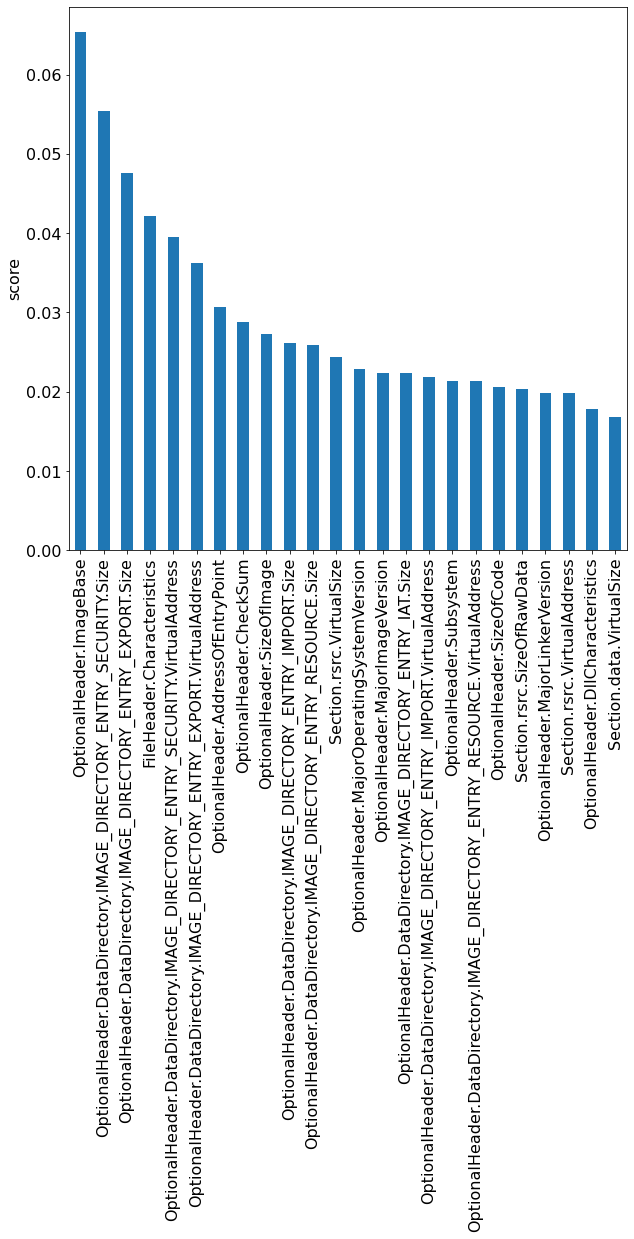

In [ ]:
def draw_feature_importance_plot():
    plt.figure(figsize=(10, 10))
    feat_importances = pd.Series(clf.feature_importances_, index=peminer_header)
    feat_importances.nlargest(24).plot(kind='bar')
    plt.ylabel("score", fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig("peminer importance")

draw_feature_importance_plot()

### 혼동 행렬

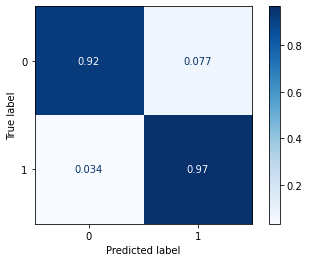

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test, normalize="true", cmap=plt.cm.Blues)
disp.figure_.savefig("실험3 PEminer") 

### 피처 차원 줄이기(Feature Selection)

In [ ]:
rfe = RFE(estimator=clf)
rfe.fit(X_train, y_train)

rfe.transform(X_train)

pipeline = Pipeline(steps=[("rfe", rfe), ("clf", clf)])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.95355

In [ ]:
# 각 특징의 히스토그램 생성 함수
def draw_countplot(df, header):
    for feature in header:
        plt.figure(figsize=(10, 10))
        plt.xlabel(f"{feature}")
        plt.title(f"{feature}")
        sns.countplot(x=f"{feature}", data=df, hue="label")
        plt.yscale("log")
        plt.savefig(f"{feature}")
        plt.close()